In [1]:
import os
import sys 
sys.path.insert(0, '/home/aiwenxu/2022-xu-retinal-degeneration')

In [2]:
import numpy as np
from model.retinasim_healthy.simulation import stim_to_retina_output
from model.retinasim_healthy.simulation_utils import SimulationParam
import pickle
from scipy.spatial import distance_matrix
from brian2 import *

In [3]:
data_folder = "../data/fig3"
if not os.path.isdir(data_folder):
    os.mkdir(data_folder)

In [6]:
sp_txt = "../model/parameter_healthy/cottaris_original_2hz.txt"
sp = SimulationParam(sp_txt)
sp.xy_coord_folder = "../model/layout_healthy/dendritic-tree-coordinate"
sp.z_coord_folder = "../model/layout_healthy/z-coordinate"

**Part 1: running retina simulation**

In [7]:
# stimulus (30 ms on square wave * 4)
NUM_CR = 4149
cr_coordinates = np.load("{}/CR.npy".format(sp.xy_coord_folder))

l_b = 0.5
l = [1, 0.7, 0.3, 0]

square_waves = []

square_waves.append(np.tile(np.ones((NUM_CR)) * l_b, (500, 1))) # before stimulation

cr_origin_dist_mat = distance_matrix(np.transpose(cr_coordinates), [np.array([0,0])])
index = np.nonzero(np.squeeze(cr_origin_dist_mat) <= 40)

square_waves.append(np.tile(np.ones((NUM_CR)) * l_b, (100, 1)))
for i in range(4):
    part = np.ones((NUM_CR)) * l_b
    part[index] = l[i]
    part = np.tile(part, (200,1))
    square_waves.append(part)
    square_waves.append(np.tile(np.ones((NUM_CR)) * l_b, (400, 1)))
stim = TimedArray(np.concatenate(square_waves, axis=0), dt=1*ms)
stim.values.shape

(3000, 4149)

In [9]:
time_in_ms = 3000
select_GPU = 1
genn_directory = "GeNNworkspace_{}".format(select_GPU)
data_cr, data_hrz, data_bp_on, data_bp_off, data_am_wf_on, data_am_wf_off, data_am_nf_on, data_gl_on, data_gl_off, spikes_gl_on, spikes_gl_off = stim_to_retina_output(time_in_ms, sp, lstim=stim, dt=0.1, select_GPU=select_GPU, genn_directory=genn_directory)

running brian code generation ...
building genn executable ...
['/home/aiwenxu/genn/bin/genn-buildmodel.sh', '-i', '/home/aiwenxu/2022-xu-retinal-degeneration/figures:/home/aiwenxu/2022-xu-retinal-degeneration/figures/GeNNworkspace_1:/home/aiwenxu/2022-xu-retinal-degeneration/figures/GeNNworkspace_1/brianlib/randomkit', 'magicnetwork_model.cpp']
executing genn binary on GPU ...
simulation time: 292.800897359848


In [10]:
with open('{}/data_cr.pickle'.format(data_folder), 'wb') as f:
    pickle.dump(data_cr, f)

with open('{}/data_hrz.pickle'.format(data_folder), 'wb') as f:
    pickle.dump(data_hrz, f)
    
with open('{}/data_bp_on.pickle'.format(data_folder), 'wb') as f:
    pickle.dump(data_bp_on, f)

with open('{}/data_bp_off.pickle'.format(data_folder), 'wb') as f:
    pickle.dump(data_bp_off, f)
    
with open('{}/data_am_wf_on.pickle'.format(data_folder), 'wb') as f:
    pickle.dump(data_am_wf_on, f)
    
with open('{}/data_am_wf_off.pickle'.format(data_folder), 'wb') as f:
    pickle.dump(data_am_wf_off, f)

with open('{}/data_am_nf_on.pickle'.format(data_folder), 'wb') as f:
    pickle.dump(data_am_nf_on, f)

with open('{}/data_gl_on.pickle'.format(data_folder), 'wb') as f:
    pickle.dump(data_gl_on, f)

with open('{}/data_gl_off.pickle'.format(data_folder), 'wb') as f:
    pickle.dump(data_gl_off, f)
    
with open('{}/spikes_gl_on.pickle'.format(data_folder), 'wb') as f:
    pickle.dump(spikes_gl_on, f)

with open('{}/spikes_gl_off.pickle'.format(data_folder), 'wb') as f:
    pickle.dump(spikes_gl_off, f)

**Part 2: spikes to spike rates**

In [11]:
from quantities import ms as neo_ms
from neo.core import SpikeTrain
from elephant.kernels import GaussianKernel
from elephant.statistics import instantaneous_rate

In [12]:
window_len = 50
cell_type = ["gl_on", "gl_off"]
for cell in cell_type:
    with open('{}/spikes_{}.pickle'.format(data_folder, cell), 'rb') as f:
        st_gl = pickle.load(f)
    spike_rates = []
    num_cells = len(st_gl['t'].keys())
    for i in range(num_cells):
        st = SpikeTrain(st_gl['t'][i]/ms*neo_ms, t_stop=3000*neo_ms)
        inst_rate = instantaneous_rate(st, sampling_period=0.1*neo_ms, kernel=GaussianKernel(window_len*neo_ms))
        spike_rates.append(inst_rate[5000:30000])
    con_spike_rates = np.concatenate(spike_rates, axis=1)
    np.save("{}/spike_rate_{}_{}.npy".format(data_folder, cell, window_len), con_spike_rates)

In [14]:
# interpolation
from model.retinasim_healthy.interp import *
coord_folder = sp.xy_coord_folder
cell_types = ["gl_on", "gl_off"]
for cell in cell_types:
    coord = np.load(coord_folder+"/"+cell.upper()+".npy")
    spike = np.load(data_folder+"/spike_rate_{}_{}.npy".format(cell, window_len))
    result = interp_wrapper(coord, spike)
    np.save(data_folder+"/interp_spike_rate_{}_{}.npy".format(cell, window_len), result)
    print("\n" + cell + " done.")

..........................................................................................................................................................................................................................................................
gl_on done.
..........................................................................................................................................................................................................................................................
gl_off done.


**Part 3: plotting**

In [15]:
def interp_y_t_plot_with_spike(path_to_interp_x_y, v_min, v_max, vert_l, path_to_spikes, cell_index):
    
    fig, axs = plt.subplots(2, 1, figsize=(15,4), sharex=True, gridspec_kw={'height_ratios': [2, 1]})
    
    interp_x_y = np.load(path_to_interp_x_y)
#     heatmap = axs[0].imshow(np.transpose(interp_x_y[:,:,50]), vmin=v_min, vmax=v_max, origin='lower', cmap=get_cmap(), aspect='auto', extent=[0,25000,0,100])
    heatmap = axs[0].imshow(np.transpose(interp_x_y[:,:,50]), vmin=v_min, vmax=v_max, origin='lower', cmap='plasma', aspect='auto', extent=[0,25000,0,100])
    axs[0].set_xticks(np.arange(0,25001,5000))
    axs[0].set_xticklabels(np.arange(0,2501,500))
    axs[0].set_yticks([0,25,50,75,100])
    axs[0].set_yticklabels([-150,-75,0,75,150])
    axs[0].set_ylabel('Space in y dimension (μm)', fontsize=10)
    for xc in vert_l:
        axs[0].axvline(x=xc*10, color='k', linestyle='--')
        
    with open(path_to_spikes, 'rb') as f:
        st = pickle.load(f)
    data = []
    for i in cell_index:
        st_example = st['t'][i]/ms
        st_example = (st_example[np.logical_and(st_example>500, st_example<3000)] - 500)*10
        data.append(st_example)
    data_c = np.concatenate([data], axis=0) # could break if the number of spikes are unequal
    axs[1].eventplot(data_c, colors='black', lineoffsets=1, linelengths=1)
    axs[1].yaxis.set_visible(False)
    axs[1].set_xlabel('Time (ms)', fontsize=10)

    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.01, 0.7])
    cbar = fig.colorbar(heatmap, cax=cbar_ax)
    cbar.set_label('firing rate (Hz)', rotation=270, labelpad=30)
    
    return fig, axs

In [16]:
def snapshots(path_to_interp_x_y, snapshot_times, v_min, v_max):
    
    fig, axs = plt.subplots(1, 6, figsize=(35,4))
    
    interp_x_y = np.load(path_to_interp_x_y)
    
    for i, t in enumerate(snapshot_times):
        axs[0].plot(interp_x_y[t][50], label='{} ms'.format(int(t/10)))
    axs[0].set_xticks([0,25,50,75,100])
    axs[0].set_xticklabels([-150,-75,0,75,150])
    axs[0].set_xlabel('Space in x dimension (μm)', fontsize=10)
    axs[0].set_ylabel('Firing rate (Hz)', fontsize=10)
    axs[0].legend()
    
    for i, t in enumerate(snapshot_times):
        axs[1].plot(interp_x_y[t][:, 50], label='{} ms'.format(int(t/10)))
    axs[1].set_xticks([0,25,50,75,100])
    axs[1].set_xticklabels([-150,-75,0,75,150])
    axs[1].set_xlabel('Space in y dimension (μm)', fontsize=10)
    axs[1].set_ylabel('Firing rate (Hz)', fontsize=10)
    axs[1].legend()
    
    for i, t in enumerate(snapshot_times):
        heatmap = axs[i+2].imshow(interp_x_y[t], vmin=v_min, vmax=v_max, origin='lower', cmap='plasma')
        axs[i+2].set_xticks([0,25,50,75,100])
        axs[i+2].set_xticklabels([-150,-75,0,75,150])
        axs[i+2].set_yticks([0,25,50,75,100])
        axs[i+2].set_yticklabels([-150,-75,0,75,150])
        axs[i+2].set_ylabel('Space in y dimension (μm)', fontsize=10)
        axs[i+2].set_xlabel('Space in x dimension (μm)', fontsize=10)
        axs[i+2].set_title('{} ms'.format(int(t/10)))
        axs[i+2].axhline(y=50, color='k', linestyle='--')
        axs[i+2].axvline(x=50, color='k', linestyle='--')

    fig.subplots_adjust(right=0.82)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.01, 0.7])
    cbar = fig.colorbar(heatmap, cax=cbar_ax)
    cbar.set_label('firing rate (Hz)', rotation=270, labelpad=30)
    
    return fig, axs

y-t plots

In [17]:
stimulus_time = np.array([100, 200, 400, 200, 400, 200, 400, 200, 400])
stimulus_time = np.cumsum(stimulus_time)

Text(0.5, 0.98, 'ON RGC')

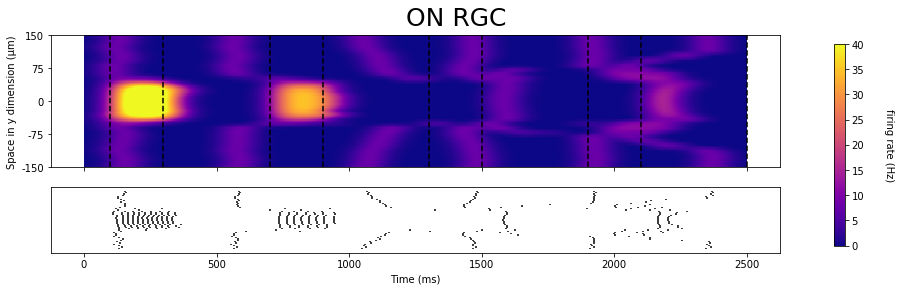

In [18]:
cell_index = [547, 520, 548, 521, 522, 493, 494, 466, 495, 467, 468, 439, 440, 412, 441, 413, 414, 385, 386, 358, 387, 359, 388, 331, 360, 332, 333, 304, 305, 306, 277, 278, 279, 250, 251, 252, 223, 224, 196, 225, 197, 171, 198, 172]
fig, axs = interp_y_t_plot_with_spike("{}/interp_spike_rate_gl_on_50.npy".format(data_folder), 0, 40, stimulus_time, "{}/spikes_gl_on.pickle".format(data_folder), cell_index)
fig.suptitle("ON RGC", fontsize=25)

Text(0.5, 0.98, 'OFF RGC')

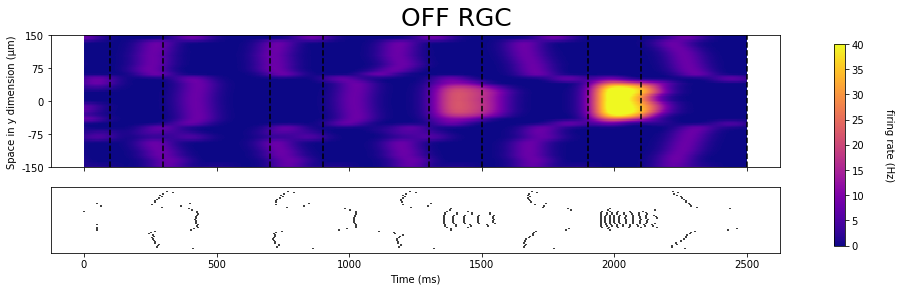

In [19]:
cell_index = [547, 548, 521, 493, 522, 523, 494, 495, 496, 467, 468, 440, 469, 441, 442, 413, 414, 415, 386, 387, 388, 359, 360, 332, 361, 333, 305, 334, 306, 278, 307, 279, 251, 280, 252, 253, 224, 225, 197, 226, 198, 172, 199, 173]
fig, axs = interp_y_t_plot_with_spike("{}/interp_spike_rate_gl_off_50.npy".format(data_folder), 0, 40, stimulus_time, "{}/spikes_gl_off.pickle".format(data_folder), cell_index)
fig.suptitle("OFF RGC", fontsize=25)

snapshots

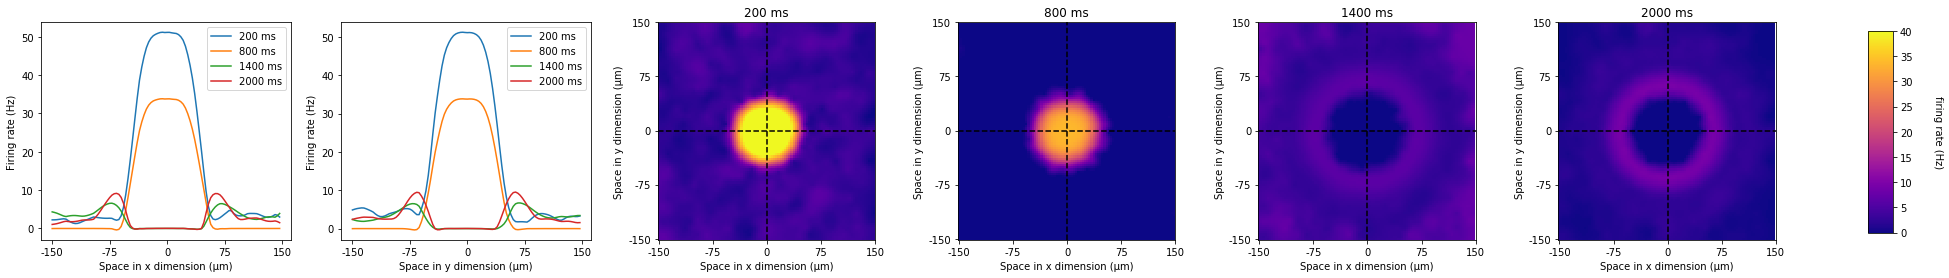

In [20]:
fig, axs = snapshots(data_folder+"/interp_spike_rate_gl_on_50.npy", [2000, 8000, 14000, 20000], 0, 40)

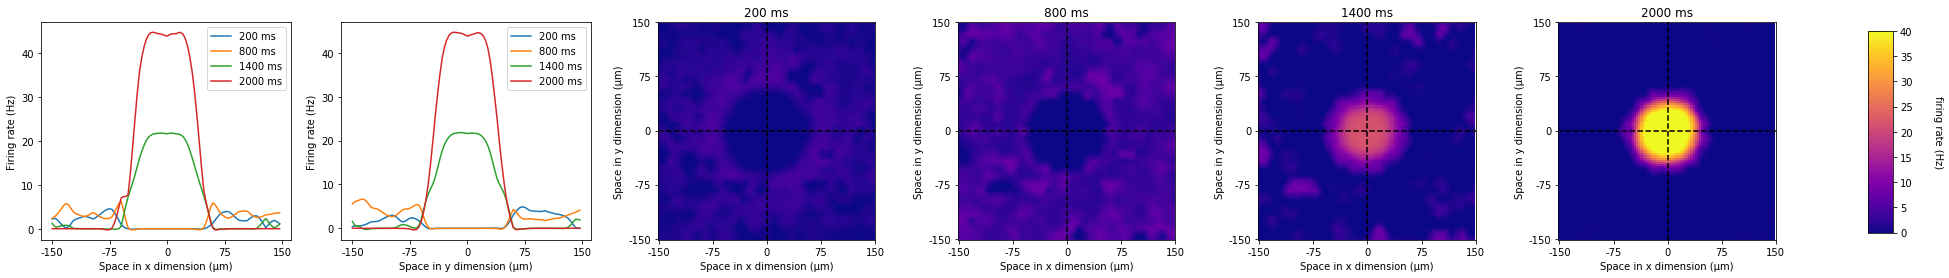

In [21]:
fig, axs = snapshots(data_folder+"/interp_spike_rate_gl_off_50.npy", [2000, 8000, 14000, 20000], 0, 40)